#Paquetes necesarios

In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

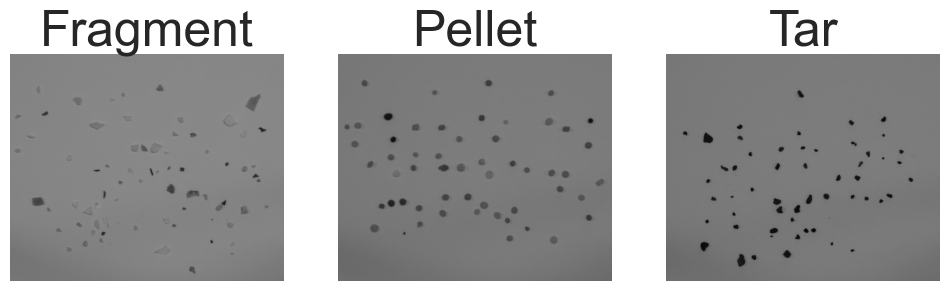

In [13]:
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Load the three images: fragments, pellets and tar

# Convert the cropped images to grayscale
frag_gray = cv2.cvtColor(frag, cv2.COLOR_BGR2GRAY)
pellet_gray = cv2.cvtColor(pellet, cv2.COLOR_BGR2GRAY)
alqui_gray = cv2.cvtColor(tar, cv2.COLOR_BGR2GRAY)

# Apply a smoothing filter to the fragment image
frag_gray = cv2.GaussianBlur(frag_gray, (19, 19), 0)
pellet_gray = cv2.GaussianBlur(pellet_gray, (29, 29), 0)



# Show the cropped images
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.title('Fragment')
plt.axis("off")
plt.imshow(cv2.cvtColor(frag_gray, cv2.COLOR_BGR2RGB))

plt.subplot(132)
plt.title('Pellet')
plt.axis("off")
plt.imshow(cv2.cvtColor(pellet_gray, cv2.COLOR_BGR2RGB))

plt.subplot(133)
plt.title('Tar')
plt.axis("off")
plt.imshow(cv2.cvtColor(alqui_gray, cv2.COLOR_BGR2RGB))

plt.show()

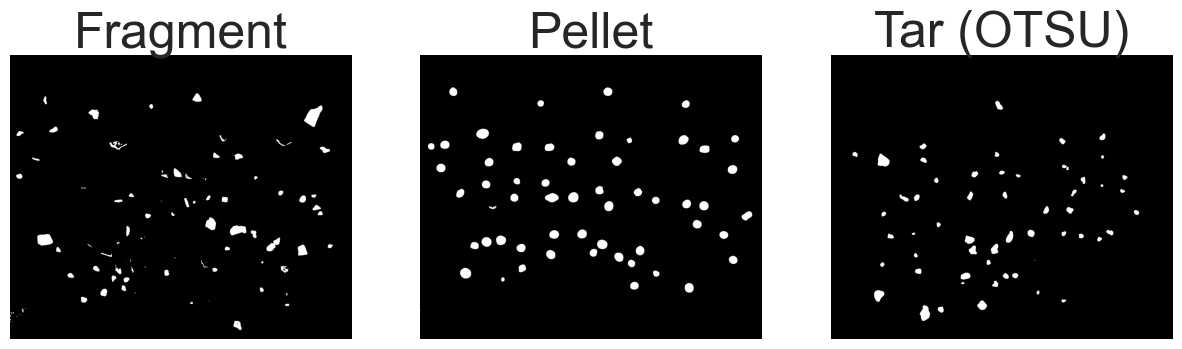

In [14]:
# Thresholding 'fragments' and 'pellet' 
# The thresholding values had to be adjusted as it detected the shadows of the sheet on which the fragments are
_,frag_umbral = cv2.threshold(frag_gray,115,255,cv2.THRESH_BINARY_INV)
_,pel_umbral = cv2.threshold(pellet_gray,104,255,cv2.THRESH_BINARY_INV)


# Thresholding with Otsu method
_,tar_umbral = cv2.threshold(alqui_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Show the thresholded images
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.title('Fragment')
plt.axis("off")
plt.imshow(frag_umbral,cmap='gray') 

plt.subplot(132)
plt.title('Pellet')
plt.axis("off")
plt.imshow(pel_umbral,cmap='gray') 

plt.subplot(133)
plt.title('Tar (OTSU)')
plt.axis("off")
plt.imshow(tar_umbral,cmap='gray') 

plt.show()

Número de Fragmentos encontrados: [65, 6, 0]
Número de Pellets encontrados: [3, 48, 0]
Número de Fragmentos de Alquitrán encontrados: [13, 1, 43]


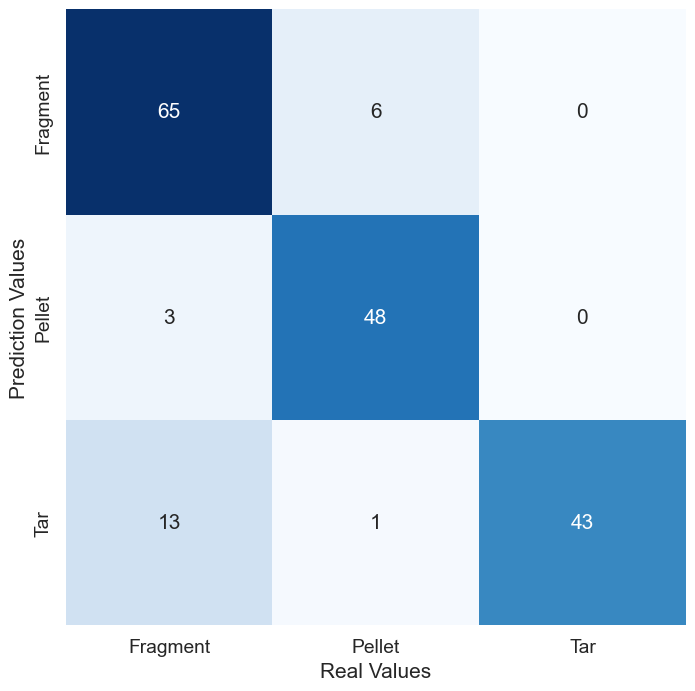

In [15]:
# Define a function to count objects in an image
def count_objects(image, original_image):
    # This function takes an image as input and returns the count of fragments, pellets, and tar objects in the image.
    
    # Find contours in the image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize counters for fragments, pellets, and tar
    fragments, pellets, tar = 0, 0, 0
    
    # Resize the original image to match the size of the input image
    original_image = cv2.resize(original_image, (image.shape[1], image.shape[0]))

    # Iterate over each contour in the image
    for contour in contours:
        # Calculate the area and perimeter of the contour
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        # Get the bounding rectangle of the contour
        _, _, w, h = cv2.boundingRect(contour)

        # Calculate the compactness of the contour (perimeter squared divided by area)
        if perimeter > 0 and area > 0:
            compactness = (perimeter ** 2) / area
        else:
            compactness = 0
        
        # Calculate the aspect ratio and area to bounding box ratio
        aspect_ratio =  w/ h
        area_container_ratio = area / (w * h)

        # Fit an ellipse to the contour
        major_axis, minor_axis, ellipse_aspect_ratio = 0, 0, 0
        if contour.shape[0] > 5:
            ellipse = cv2.fitEllipse(contour)
            major_axis = ellipse[1][1]
            minor_axis = ellipse[1][0]
            ellipse_aspect_ratio = minor_axis / major_axis
        
        # Calculate the eccentricity of the ellipse
        eccentricity = 0
        if major_axis > 0:
            eccentricity = np.sqrt(1 - (minor_axis ** 2 / major_axis ** 2))

        # Calculate the solidity of the contour (area divided by convex hull area)
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0

        # Create a mask for the contour
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)

        # Calculate the mean color value of the contour
        mean_val = cv2.mean(original_image, mask=mask)[:3]

        # Approximate the contour using the Ramer-Douglas-Peucker algorithm
        epsilon = 0.02 * cv2.arcLength(contour, True)  # Adjust epsilon for approximation accuracy
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Count the number of corners (vertices)
        

         
        # Calculate the circularity of the contour (4 * pi * area divided by perimeter squared)
        if(perimeter > 0):
            circularity = (4 * np.pi * area) / ((perimeter) ** 2)
        else:
             circularity = 0

        # Classify the contour as a fragment, pellet, or tar based on its properties
        if area_container_ratio < 0.65 and ellipse_aspect_ratio < 0.78:
            fragments += 1
        # Classification criteria for fragments, pellets, and tar
        elif compactness < 14.8 and np.isclose(aspect_ratio, 1.0, rtol=1) and circularity > 0.85:
                pellets += 1
        elif np.mean(mean_val) < 50:
            # Clasificación por color oscuro para tar
             # Los tar suelen ser oscuros
            tar += 1
       
        

    # Return the counts of fragments, pellets, and tar
    return [fragments, pellets, tar]



# Counting objects in the thresholded images

# Count objects in the thresholded fragment image
total_fragments, total_pellets, total_tar = count_objects(frag_umbral, frag), count_objects(pel_umbral, pellet), count_objects(tar_umbral, tar)

# Create a confusion matrix to display the counts
confusion_matrix = np.array([total_fragments, total_pellets, total_tar])
print(f"Número de Fragmentos encontrados: {total_fragments}")
print(f"Número de Pellets encontrados: {total_pellets}")
print(f"Número de Fragmentos de Alquitrán encontrados: {total_tar}")

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.25)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cbar=False, cmap='Blues', 
            xticklabels=['Fragment', 'Pellet', 'Tar'], 
            yticklabels=['Fragment', 'Pellet', 'Tar'])
plt.xlabel("Real Values")
plt.ylabel("Prediction Values")
plt.show()